In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
xls= pd.ExcelFile("Data case 1 final 2025 IIALM.xlsx")
print(xls.sheet_names)

['Question 1', 'Question 2', 'Question 3 ']


In [126]:
df = pd.read_excel(xls, sheet_name="Question 2", header=2)
df.columns = df.columns.str.strip()
print(df.head())

   Maturity (yrs)  Cash flow (x 1,000)  Zero rates  Shocked curve
0               1        307223.552733    0.023870       0.018870
1               2        310705.215242    0.022586       0.017586
2               3        315035.697821    0.022560       0.017560
3               4        321173.260347    0.022834       0.017834
4               5        329175.868998    0.022999       0.017999


In [ ]:
# Get the cash flows and zero rates (convert them into appropriate units if necessary)
cash_flows = df["Cash flow (x 1,000)"] *1000 # Cash flows in x1000
zero_rates = df["Zero rates"]  # Zero rates 

# Time periods (years)
time_periods = df["Maturity (yrs)"]

# Calculate Present Value (PV) of each cash flow
discount_factors = (1 + zero_rates) ** time_periods
pv_cash_flows = cash_flows / discount_factors

# calculate modified duration
mod_duration_terms = (pv_cash_flows / pv_cash_flows.sum()) *  (time_periods/ (1+zero_rates))
modified_duration = mod_duration_terms.sum()
# Calculate the Price of the liability (sum of PVs)
price = pv_cash_flows.sum()

# Calculate the Modified DV01
modified_dv01 = modified_duration * price / 10000
modified_dv01_print = modified_dv01/1000000 # for notation

# Results
print(f"Modified Duration: {modified_duration:.2f} years")
print(f"Modified DV01: EUR {modified_dv01_print:.2f} million")
print(pv_cash_flows.sum())

Modified Duration: 17.98 years
Modified DV01: EUR 16.92 million
9410773503.657024


17.98086598034138


/var/folders/wd/xhqbxbf16glgyh1kg9w4cx040000gn/T/ipykernel_45296/1764743980.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_contributions = mod_duration_terms.groupby(maturity_buckets).sum()


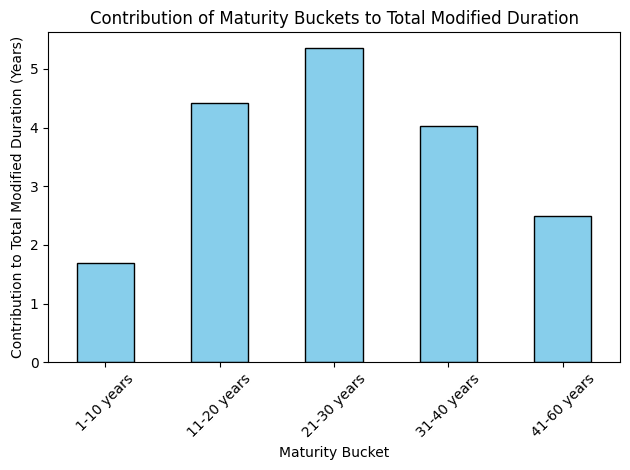

In [128]:
maturity_buckets = pd.cut(time_periods, bins=[0, 10, 20, 30, 40, 60], right=True,
                          labels=["1-10 years", "11-20 years", "21-30 years", "31-40 years", "41-60 years"])
bucket_contributions = mod_duration_terms.groupby(maturity_buckets).sum()
print(bucket_contributions.sum())
# Plotting the results
bucket_contributions_percentage = bucket_contributions / bucket_contributions.sum() * 100
bucket_contributions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Contribution of Maturity Buckets to Total Modified Duration')
plt.xlabel('Maturity Bucket')
plt.ylabel('Contribution to Total Modified Duration (Years)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**2b**

In [142]:
#
old_pv = pv_cash_flows.sum()
print(old_pv)
shocked_zero_rates = zero_rates - 0.008
shocked_discount_factors = (1 + shocked_zero_rates) ** time_periods
shocked_pv_cash_flows = cash_flows / shocked_discount_factors
new_pv = shocked_pv_cash_flows.sum()
print(new_pv)
price_change = new_pv - old_pv
print(price_change)
dv01_impact = modified_dv01 * 80
print(dv01_impact)
mod_convexity_terms = (pv_cash_flows * (time_periods**2 + time_periods))/ (((1+zero_rates) ** 2) * old_pv)
modified_convexity = mod_convexity_terms.sum()
mod_convexity_impact = 0.5 * modified_convexity * (-0.008)**2 * old_pv # is dit wel de basis point change????
print(mod_convexity_impact)
total_impact = mod_convexity_impact + dv01_impact
print(total_impact)
print(f"Unexplained Difference: {price_change - abs(total_impact):.2f}")


9410773503.657024
10924172497.070324
1513398993.4132996
1353710857.124837
145734756.2129655
1499445613.3378024
Unexplained Difference: 13953380.08


In [130]:
FR_old = 1.3
total_assets= FR_old * old_pv
FR_new = total_assets / new_pv
print(FR_new)

1.11990226793243


**2c**

In [131]:
swap_rate_5 = 0.02299
swap_rate_30 = 0.02216
years = np.arange(1, 31)
notional_5 = 6000000000

In [132]:
#Set target values for DV01 based on liabilities
target_dv01 = modified_dv01
want_to_hedge = modified_dv01 *1.3
print(f"Target DV01 (liabilities): {target_dv01:,.2f}")
print(f"Desired DV01 to hedge: {want_to_hedge:,.2f}")

# Calculate the DV01 from investing the cash in a 1-year zero coupon bond
cash = total_assets
print(f"Total assets (cash): {cash:,.2f}")
mod_dv01_zcb = cash / (10000 * (1 + zero_rates[0]))
print(f"DV01 from zero coupon bonds: {mod_dv01_zcb:,.2f}")


# 5-Year Swap: Only the final (5th) year contributes with the full notional

DVO1_swap_5_fixed = 0
DV01_5 = np.zeros(5)
for t in range(1, 6):
    if t != 5:
        # For year 1-4,
        DVO1 = (t * ((( swap_rate_5) * 6000000000) / ((1 + zero_rates.iloc[t-1])**t))) / (10000 * (1 + zero_rates.iloc[t-1]))
    else:
        # For years 5.
        DVO1 = (t* ((1+swap_rate_5) * 6000000000) / ((1 + zero_rates.iloc[t-1])**t)) / (10000 * (1 + zero_rates.iloc[t-1]))
    DV01_5[t-1] = DVO1
    DVO1_swap_5_fixed += DVO1

print(f"5-year swap fixed leg DV01 (only year 5 contributes): {DVO1_swap_5_fixed:,.2f}")

# Calculate the floating leg DV01 for the 5-year swap
mod_dv01_5_floating = (1 / ((1 + zero_rates[0]) * 10000)) * notional_5
print(f"5-year swap floating leg DV01: {mod_dv01_5_floating:,.2f}")

# Net DV01 for the 5-year swap is the fixed leg DV01 minus the floating leg DV01
mod_dv01_swap_5 = DVO1_swap_5_fixed - mod_dv01_5_floating
print(f"Net 5-year swap DV01 (fixed - floating): {mod_dv01_swap_5:,.2f}")

# Hedging DV01 contributed by the 5-year swap
dv01_hedge = mod_dv01_swap_5
print(f"Hedging DV01 from 5-year swap (Net DV01 * Notional): {dv01_hedge:,.2f}")

# 30-Year Swap Calculation
mod_dv01_30_fixed_terms = (time_periods * (1 + swap_rate_30) / ((1 + zero_rates)**time_periods)) / (10000 * (1 + zero_rates))
mod_dv01_30_fixed = mod_dv01_30_fixed_terms[:30].sum()
mod_dv01_30_floating = 1 / ((1 + zero_rates[0]) * 10000)
DVO1_swap_30_fixed = 0
DV01_30 = np.zeros(30)
for t in range(1, 31):
    if t != 30:
        DVO1 = (t * (swap_rate_30 / ((1 + zero_rates.iloc[t-1])**t))) / (10000 * (1 + zero_rates.iloc[t-1]))
    else:
        DVO1 = (t * ((1 + swap_rate_30) / ((1 + zero_rates.iloc[t-1])**t))) / (10000 * (1 + zero_rates.iloc[t-1]))
    DV01_30[t-1] = DVO1
    DVO1_swap_30_fixed += DVO1

mod_dv01_swap_30 = DVO1_swap_30_fixed - mod_dv01_30_floating
print(f"30-year swap DV01 (fixed - floating): {mod_dv01_swap_30:,.8f}")

# Calculate the remaining DV01 to hedge after considering cash and the 5-year swap
remaining_dv01 = want_to_hedge - dv01_hedge - mod_dv01_zcb
print(f"Remaining DV01 to hedge (after 5-year swap and zero coupon bonds): {remaining_dv01:,.2f}")

# Calculate the required notional for the 30-year swap to match the remaining DV01
notional_30 = remaining_dv01 / mod_dv01_swap_30
print(f"Required notional for 30-year swap: {notional_30:,.2f}")

Target DV01 (liabilities): 16,921,385.71
Desired DV01 to hedge: 21,997,801.43
Total assets (cash): 12,234,005,554.75
DV01 from zero coupon bonds: 1,194,878.80
5-year swap fixed leg DV01 (only year 5 contributes): 2,803,674.78
5-year swap floating leg DV01: 586,011.90
Net 5-year swap DV01 (fixed - floating): 2,217,662.89
Hedging DV01 from 5-year swap (Net DV01 * Notional): 2,217,662.89
30-year swap DV01 (fixed - floating): 0.00208861
Remaining DV01 to hedge (after 5-year swap and zero coupon bonds): 18,585,259.74
Required notional for 30-year swap: 8,898,382,016.15


**2d**

In [133]:
V_swap_30_fixed = 0
V_swap_30 = np.zeros(30)
for t in range(1, 31):
    if t < 30:
        V = (swap_rate_30 / ((1 + shocked_zero_rates.iloc[t-1])**t))
    else:
        V = ((1 + swap_rate_30) / ((1 + shocked_zero_rates.iloc[t-1])**t))
    V_swap_30[t-1] = V
    V_swap_30_fixed += V

V_swap_30_fixed *= notional_30
print(f"Value of 30-year swap fixed leg: {V_swap_30_fixed:,.2f}")


Value of 30-year swap fixed leg: 10,638,602,564.16


In [134]:
V_swap_30_floating = notional_30* (((1 + zero_rates[0]/1+shocked_zero_rates.iloc[0])))
print(f"30-year swap floating leg value: {V_swap_30_floating:,.2f}")

PV_swap_30 = V_swap_30_fixed - V_swap_30_floating
print(f"Net 30-year swap value (fixed - floating): {PV_swap_30:,.2f}")


30-year swap floating leg value: 9,252,003,717.48
Net 30-year swap value (fixed - floating): 1,386,598,846.69


In [135]:
mod_dur_30_swap = mod_dv01_swap_30*10000/PV_swap_30
print(f"Modified Duration of 30-year swap: {mod_dur_30_swap:,.2f}")


Modified Duration of 30-year swap: 0.00


e

In [136]:
new_zero_curve = df["Shocked curve"]

In [137]:
liabilities_shock_e = sum([
    cash_flows.iloc[t] / (1 + new_zero_curve.iloc[t])**(t+1)
    for t in range(len(cash_flows))
])
print(liabilities_shock_e)


10710441885.064337


In [141]:
# Revalue Cash using the shocked 1-year rate
PV_cash_shocked = (total_assets * (1 + zero_rates.iloc[0])) / (1 + new_zero_curve.iloc[0])

# Revalue the 5-Year Swap Fixed Leg under Shock
PV_swap_5_fixed_shock = sum([
    (swap_rate_5 * notional_5) / (1 + new_zero_curve.iloc[t-1])**t
    for t in range(1, 5)
])
PV_swap_5_fixed_shock += ((1 + swap_rate_5) * notional_5) / (1 + new_zero_curve.iloc[4])**5

# Revalue the 5-Year Swap Floating Leg (simplified approach)
PV_swap_5_floating_shock = notional_5 * (1 + zero_rates.iloc[0]) / (1 + new_zero_curve.iloc[0])

# Net PV of the 5-Year Swap under Shock
PV_swap_5_shock = PV_swap_5_fixed_shock - PV_swap_5_floating_shock

# Revalue the 30-Year Swap Fixed Leg under Shock
PV_swap_30_fixed_shock = sum([
    (swap_rate_30 * notional_30) / (1 + new_zero_curve.iloc[t-1])**t
    for t in range(1, 30)
])
PV_swap_30_fixed_shock += ((1 + swap_rate_30) * notional_30) / (1 + new_zero_curve.iloc[29])**30

# Revalue the 30-Year Swap Floating Leg (simplified approach)
PV_swap_30_floating_shock = notional_30 * (1 + zero_rates.iloc[0]) / (1 + new_zero_curve.iloc[0])

# Net PV of the 30-Year Swap under Shock
PV_swap_30_shock = PV_swap_30_fixed_shock - PV_swap_30_floating_shock

# Total revalued assets (cash plus net swap values) under the shocked curve
assets_shock_e = PV_cash_shocked + PV_swap_5_shock + PV_swap_30_shock

# Print only the final total
print("Total Assets under shocked curve: €{0:,.2f}".format(assets_shock_e))


Total Assets under shocked curve: €13,600,112,173.66


f

In [146]:
liabilities_shock_e = sum([
    cash_flows.iloc[t] / (1 + shocked_zero_rates.iloc[t])**(t+1)
    for t in range(len(cash_flows))
])
print(liabilities_shock_e)


10924172497.07032


In [145]:
PV_cash_shocked = (total_assets * (1 + zero_rates.iloc[0])) / (1 + shocked_zero_rates.iloc[0])

PV_swap_5_fixed_shock = sum([(swap_rate_5 * notional_5) / (1 + shocked_zero_rates.iloc[t-1])**t for t in range(1, 5)])
PV_swap_5_fixed_shock += ((1 + swap_rate_5) * notional_5) / (1 + shocked_zero_rates.iloc[4])**5
PV_swap_5_floating_shock = notional_5 * (1 + zero_rates.iloc[0])/ (1 + shocked_zero_rates.iloc[0])
PV_swap_5_shock = PV_swap_5_fixed_shock - PV_swap_5_floating_shock

PV_swap_30_fixed_shock = sum([(swap_rate_30 * notional_30) / (1 + shocked_zero_rates.iloc[t-1])**t for t in range(1, 30)])
PV_swap_30_fixed_shock += ((1 + swap_rate_30) * notional_30) / (1 + shocked_zero_rates.iloc[29])**30
PV_swap_30_floating_shock =notional_30 * (1 + shocked_zero_rates.iloc[0]) / (1 + shocked_zero_rates.iloc[0])
PV_swap_30_shock = PV_swap_30_fixed_shock - PV_swap_30_floating_shock

assets_shock_e = PV_cash_shocked + PV_swap_5_shock + PV_swap_30_shock
print(assets_shock_e)

14252890646.357864


In [147]:
funding_ratio_shocked = (assets_shock_e / liabilities_shock_e) * 100
print("Funding Ratio after shock is: ", funding_ratio_shocked)

Funding Ratio after shock is:  130.4711240158488


g

In [153]:
swap_rate_20 = 0.02415
swap_rate_30 = 0.02216
swap_rate_40 = 0.020841


In [150]:
def compute_mod_dv01(swap_rate, maturity, zero_rates):
    dv01_fixed = 0
    for t in range(1, maturity + 1):
        if t != maturity:
            DVO1 = (t * (swap_rate / ((1 + zero_rates.iloc[t-1])**t))) / (10000 * (1 + zero_rates.iloc[t-1]))
        else:
            DVO1 = (t * ((1 + swap_rate) / ((1 + zero_rates.iloc[t-1])**t))) / (10000 * (1 + zero_rates.iloc[t-1]))
        dv01_fixed += DVO1
    dv01_floating = 1 / ((1 + zero_rates.iloc[0]) * 10000)
    return dv01_fixed - dv01_floating



In [156]:
mod_dv01_20 = compute_mod_dv01(swap_rate_20, 20, zero_rates)
mod_dv01_30 = compute_mod_dv01(swap_rate_30, 30, zero_rates)
mod_dv01_40 = compute_mod_dv01(swap_rate_40, 40, zero_rates)

print(f"20-year swap DV01: {mod_dv01_20:,.2f}")
print(f"30-year swap DV01: {mod_dv01_30:,.2f}")
print(f"40-year swap DV01: {mod_dv01_40:,.2f}")


20-year swap DV01: 0.00
30-year swap DV01: 0.00
40-year swap DV01: 0.00
